In [1]:
# Import packages

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import *
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from scipy import stats
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import statsmodels.api as sm
from tslearn.clustering import TimeSeriesKMeans
from urllib.request import urlopen
import plotly.express as px
import scipy.cluster.hierarchy as hac
import scipy
import json
import censusdata

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.6.2-CAPI-1.10.2 4d2925d6) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## Constants

# Number of days to smooth data
SMOOTH = 7

In [3]:
# This will come in handy later

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

#### Read in data and prepare such that we have a smoothed time series of new cases per day for each county. Can easily toggle to using deaths if needed

In [4]:
# Read in John's Hopkins data

county_cases = pd.read_csv("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
county_deaths = pd.read_csv("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

# Read in New York Time's data
county_nyt = pd.read_csv("../covid-19-data/us-counties.csv")

county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5753,5811,5824,5856,5869,5881,5910,5930,5970,5984
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,18418,18494,18568,18668,18723,18763,18824,18888,18960,18994
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1981,1989,1994,2002,2008,2008,2019,2024,2030,2036
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2321,2327,2331,2334,2339,2346,2362,2368,2377,2385
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5768,5842,5871,5908,5915,5920,5929,5937,5955,5953


In [5]:
# Uncomment to use deaths

county_cases = county_deaths.copy()

In [6]:
# Filter out just to get to the 50 states + District of Columbia
provinces = list(county_cases.Province_State.unique())
to_remove = ['Diamond Princess', 'Guam', 'Grand Princess', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']
states = [x for x in provinces if x not in to_remove]
county_cases = county_cases[county_cases.Province_State.isin(states)]
county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,71,74,76,77,77,77,77,79,81,84
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,228,233,234,227,227,227,228,239,240,251
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,42,43,44,45,45,45,45,46,46,48
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,52,53,53,53,53,54,54,57
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,105,109,111,112,112,112,113,116,116,121


In [7]:
# Some pre-processing

county_cases = county_cases[~county_cases.FIPS.isna()].reset_index(drop=True)
county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,71,74,76,77,77,77,77,79,81,84
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,228,233,234,227,227,227,228,239,240,251
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,42,43,44,45,45,45,45,46,46,48
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,52,53,53,53,53,54,54,57
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,105,109,111,112,112,112,113,116,116,121


In [8]:
# Remove counties with no cases
dates = county_cases.columns[12:]
print(dates)

# Array to hold indices
zero_cases = []

# Find all counties with no cases
for i in range(len(county_cases)):
    if np.all(county_cases[dates].values[i] == 0):
        zero_cases.append(i)

print(len(county_cases))
county_cases = county_cases.drop(zero_cases, axis=0)
print(len(county_cases))
# print(zero_cases)

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/3/21', '2/4/21', '2/5/21', '2/6/21', '2/7/21', '2/8/21', '2/9/21',
       '2/10/21', '2/11/21', '2/12/21'],
      dtype='object', length=388)
3245
3119


In [9]:
# Get the number of new cases per day, casting anything that is less than 0 (or nan values) to 0

new_cases = county_cases[["FIPS", "Province_State", "Admin2", dates[0]]].copy()
for i in range(1, len(dates)):
    curr_date = dates[i]
    last_date = dates[i-1]
    diff = (county_cases[curr_date] - county_cases[last_date]).values
    new_cases[curr_date] = np.where((diff >= 0) | (np.isnan(diff)), diff, 0) 
#     print(len(diff))
#     print(diff)
#     for j in range(len(diff)):
# #         print(diff[j])
#         if diff[j] < 0:
#             if j == 0:
#                 diff[j] = 0
#             elif j == len(diff)-1:
#                 diff[j] = diff[j-1]
#             else:
#                 diff[j] = (diff[j-1] + diff[j+1]) / 2
#     new_cases[curr_date] = diff


new_cases.head()

,FIPS,Province_State,Admin2,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,1001.0,Alabama,Autauga,0,0,0,0,0,0,0,...,1,3,2,1,0,0,0,2,2,3
1,1003.0,Alabama,Baldwin,0,0,0,0,0,0,0,...,0,5,1,0,0,0,1,11,1,11
2,1005.0,Alabama,Barbour,0,0,0,0,0,0,0,...,2,1,1,1,0,0,0,1,0,2
3,1007.0,Alabama,Bibb,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
4,1009.0,Alabama,Blount,0,0,0,0,0,0,0,...,4,4,2,1,0,0,1,3,0,5


In [10]:
# Apply a smooth

smoothed_df = county_cases[["FIPS", "Province_State", "Admin2"]].copy()
for i in range(SMOOTH-1, len(dates)):
    date_range = dates[i-SMOOTH+1:i+1]
    smoothed_df[dates[i]] = np.mean(new_cases[date_range], axis=1)
    
smoothed_df.head() 

,FIPS,Province_State,Admin2,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,1001.0,Alabama,Autauga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.571429,0.714286,1.000000,1.142857,1.142857,1.142857,1.000000,1.142857,1.000000,1.142857
1,1003.0,Alabama,Baldwin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.714286,1.285714,1.428571,1.428571,1.428571,1.428571,1.000000,2.571429,2.000000,3.428571
2,1005.0,Alabama,Barbour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.285714,0.428571,0.571429,0.714286,0.714286,0.714286,0.714286,0.571429,0.428571,0.571429
3,1007.0,Alabama,Bibb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.142857,0.142857,0.285714,0.142857,0.142857,0.142857,0.285714,0.285714,0.714286
4,1009.0,Alabama,Blount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.428571,1.571429,1.857143,2.000000,1.714286,1.714286,1.714286,1.571429,1.000000,1.428571


In [11]:
smoothed_df.loc[smoothed_df.Province_State == "Alabama"][date_range]

,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,1.142857,1.142857,1.142857,1.000000,1.142857,1.000000,1.142857
1,1.428571,1.428571,1.428571,1.000000,2.571429,2.000000,3.428571
2,0.714286,0.714286,0.714286,0.714286,0.571429,0.428571,0.571429
3,0.285714,0.142857,0.142857,0.142857,0.285714,0.285714,0.714286
4,2.000000,1.714286,1.714286,1.714286,1.571429,1.000000,1.428571
...,...,...,...,...,...,...,...
64,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
65,2.142857,1.714286,1.714286,1.285714,3.571429,4.000000,4.142857
66,0.285714,0.285714,0.285714,0.428571,0.142857,0.285714,0.285714
67,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.285714


In [12]:
# Set this to the dataframe to be used and the date range

df = smoothed_df.copy()
date_range = dates[SMOOTH-1:]
n_days = len(date_range)
m = n_days

In [13]:
df.shape

(3119, 385)

68


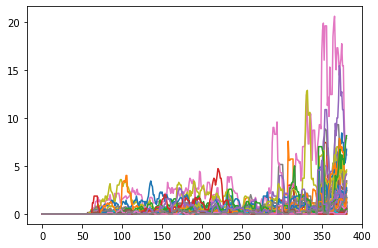

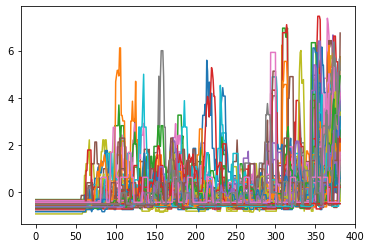

In [14]:
# We can plot a state just to look at some of the counties and make sure this process worked
plot_state = "Alabama"

print(len(df[df.Province_State == plot_state]))

plt.figure()
plt.plot(df[df.Province_State == plot_state][date_range].values.T)
plt.show()

plt.figure()
plt.plot(scipy.stats.zscore(df[df.Province_State == plot_state][date_range].values, axis=1).T)
plt.show()

#### Now, we can start our clustering process

In [15]:
# useful function to plot a matrix
def plot_matrix(m, rows, title='', x_axis_label='', y_axis_label='', save_plot=False, plot_name=''):
    plt.figure()
    for i in range(rows):
        plt.plot(m.T[:,i], label=str(i))
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    if save_plot:
        plt.savefig('../figures/%s'%(plot_name))
    plt.show()

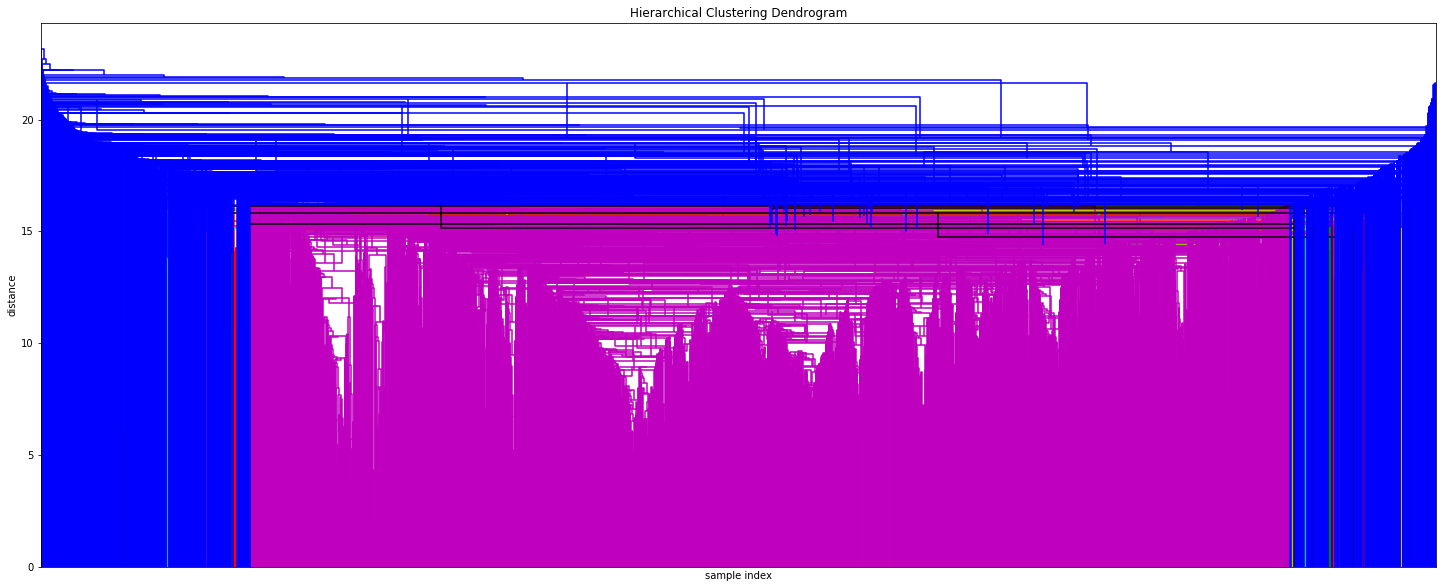

In [16]:
# Z-score all the data
# Data matrices
all_data = df[date_range].values
data = scipy.stats.zscore(all_data, axis=1)

# Do the clustering
Z = hac.linkage(data, method='centroid', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.xticks([])
plt.show()

In [17]:
def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.loc[cluster_indeces, dates].T.plot()
            plt.show()

print_clusters(county_cases, Z, 3, plot=False)

Cluster 1 number of entries 3117
Cluster 3 number of entries 1
Cluster 2 number of entries 1


In [18]:
# Fit k means by generating elbow plot

errors = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    errors.append(kmeans.inertia_)


In [19]:
import seaborn as sns

sns.set(
        rc={
 "axes.axisbelow": True,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "#1D1C1C",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "#1D1C1C",
#  "xtick.bottom": False,
 "xtick.color": "#1D1C1C",
 "xtick.direction": "out",
#  "xtick.top": False,
 "ytick.color": "#1D1C1C",
 "ytick.direction": "out"})
#  "ytick.left": False,
#  "ytick.right": False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

# font = {'fontname':'Tahoma'}

In [20]:
p = sns.color_palette('Paired')
p.as_hex()

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [21]:
import os
from matplotlib import font_manager as fm, rcParams
# Point to font file
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/Helvetica.ttf")
prop = fm.FontProperties(fname=fpath)

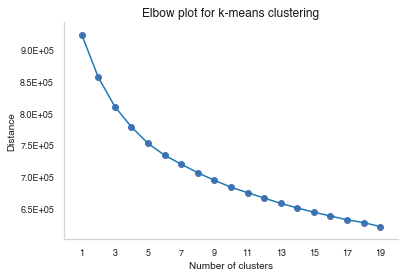

In [22]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(errors, color='#1f78b4')
ax.set_xticks([i for i in range(0,19)][::2])
ax.set_xticklabels([i+1 for i in range(0,19)][::2], fontproperties=prop, fontsize=9)
ax.scatter([i for i in range(len(errors))], errors)
ax.set_yticklabels(['%.1E'%(q) for q in ax.get_yticks()], fontproperties=prop, fontsize=9)
ax.set_xlabel("Number of clusters", fontproperties=prop, fontsize=10)
ax.set_ylabel("Distance", fontproperties=prop, fontsize=10)
ax.set_title("Elbow plot for k-means clustering", fontproperties=prop, fontsize=12)
# plt.tight_layout()
sns.despine(top=True, bottom=False, left=False, right=True)
plt.savefig("../figures/paper/elbow_plot.pdf", dpi=150, bbox_inches='tight')
plt.show()

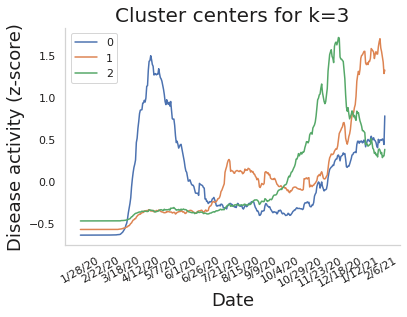

In [28]:
# Plot the cluster centers
k=3
kmeans = TimeSeriesKMeans(n_clusters=k, metric='euclidean', n_init=10).fit(data)
centers = kmeans.cluster_centers_
centers = centers.reshape(centers.shape[0], centers.shape[1])


plt.figure()
for i in range(k):
    plt.plot(centers.T[:,i], label=str(i))
plt.title("Cluster centers for k=%i"%(k))
plt.xticks([i for i in range(len(date_range))][::25], date_range[::25], rotation=30)
plt.xlabel("Date")
plt.ylabel("Disease activity (z-score)")
plt.legend()
# plt.savefig('../figures/%s'%("centers_k3.png"), dpi=300)
plt.show()


In [29]:
cents = pd.DataFrame(centers, columns=date_range)
cents.to_csv("../data/centers.csv", index=False)
cents.head()

,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,-0.639056,-0.639056,-0.639056,-0.639056,-0.639056,-0.639056,-0.639056,-0.639056,-0.639056,-0.639056,...,0.400571,0.500381,0.461482,0.492586,0.495327,0.488891,0.504916,0.496861,0.439435,0.778813
1,-0.571817,-0.571817,-0.571817,-0.571817,-0.571817,-0.571817,-0.571817,-0.571817,-0.571817,-0.571817,...,1.514110,1.603779,1.660766,1.697049,1.586467,1.543022,1.480116,1.418981,1.283230,1.322969
2,-0.470249,-0.470249,-0.470249,-0.470249,-0.470249,-0.470249,-0.470249,-0.470249,-0.470249,-0.470249,...,0.290553,0.375642,0.386292,0.370928,0.328992,0.344684,0.282805,0.303088,0.303532,0.380981


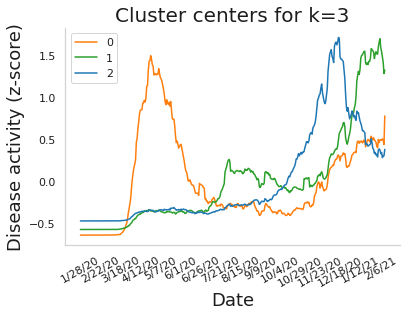

In [30]:
name_to_hex = {'green':'#2ca02c', 'blue':'#1f77b4', 'orange':'#ff7f0e'}
## COLOR mapping: '#2ca02c' (green) '#1f77b4' (blue) '#ff7f0e' (orange)
label_change = {1:'still increasing', 2:'early peak', 0:'late peak'}
label_color_mapping = {'early peak':'blue', 'late peak':'orange', 'still increasing':'green'}


plt.figure()
for i in range(k):
    plt.plot(centers.T[:,i], label=str(i), color=name_to_hex[label_color_mapping[label_change[i]]])
plt.title("Cluster centers for k=%i"%(k))
plt.xticks([i for i in range(len(date_range))][::25], date_range[::25], rotation=30)
plt.xlabel("Date")
plt.ylabel("Disease activity (z-score)")
plt.legend()
plt.savefig('../figures/clustering/%s'%("centers_k3.png"), dpi=300)
plt.show()

In [31]:
# Assign clusters and slightly alter our fips ids so that they all have leading zeros
df['cluster'] = kmeans.labels_
df['fips'] = df['FIPS'].astype(int).astype(str)
df['fips'] = [x.zfill(5) for x in df.fips]
print(np.unique(df.cluster.values, return_counts=True))
df[['FIPS', 'cluster']].to_csv("../data/cluster_assignment.csv", index=False)
df.head()

(array([0, 1, 2]), array([ 360, 1461, 1298]))


,FIPS,Province_State,Admin2,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,...,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,cluster,fips
0,1001.0,Alabama,Autauga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.142857,1.142857,1.142857,1.000000,1.142857,1.000000,1.142857,1,01001
1,1003.0,Alabama,Baldwin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.428571,1.428571,1.428571,1.428571,1.000000,2.571429,2.000000,3.428571,1,01003
2,1005.0,Alabama,Barbour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.571429,0.714286,0.714286,0.714286,0.714286,0.571429,0.428571,0.571429,2,01005
3,1007.0,Alabama,Bibb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.285714,0.142857,0.142857,0.142857,0.285714,0.285714,0.714286,2,01007
4,1009.0,Alabama,Blount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.857143,2.000000,1.714286,1.714286,1.714286,1.571429,1.000000,1.428571,1,01009


In [31]:
df_for_csv = df[['FIPS', 'Province_State', 'Admin2', 'cluster']]
df_for_csv.to_csv('../data/county_cluster.csv', index=False)